## table of contents
1. [overall](#overall)
2. [model](#model)
3. [explainable ai](#explainable_ai)
4. [test](#test)
5. [profitability](#profitability)

___
## overall

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import shap
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances

import mlframework

/Users/khanhtpd/opt/anaconda3/envs/mlframework/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_parquet('/Users/khanhtpd/Projects/aai_banca_ls_v3/model/banca_hub_202203/banca_202101/part-00000-7624f56d-d0fc-4f83-abe5-47b984dc8b54-c000.snappy.parquet')
data['AGE'] = data['AGE'].astype(float)
data = data.sample(10000)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 11065 to 56424
Columns: 502 entries, REF_TIME to LENDING_SUM_BAL_3M
dtypes: float64(496), int32(3), object(3)
memory usage: 38.3+ MB


,REF_TIME,CUSID,LABEL_TIME,LABEL,GENDER,CITY,AGE,MONTH_ON_BANK,CASA_BAL_MEAN_BAL_INCREASE_GREATER_1E6_6M,CASA_BAL_MEAN_BAL_INCREASE_GREATER_30E6_6M,...,LENDING_MAX_BAL_6M,LENDING_VARIANCE_BAL_6M,LENDING_MEAN_BAL_6M,LENDING_VARIANCE_BAL_3M,LENDING_MAX_BAL_3M,LENDING_MIN_BAL_6M,LENDING_SUM_BAL_6M,LENDING_MIN_BAL_3M,LENDING_MEAN_BAL_3M,LENDING_SUM_BAL_3M
11065,20210831,25974296,202110,0,FEMALE,HO-CHI-MINH,47.0,110.0,0.099448,0.011050,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54972,20200831,24626708,202010,0,MALE,TAY-NINH,27.0,108.0,0.005495,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7402,20200731,35093151,202009,0,MALE,LAM-DONG,57.0,18.0,0.027473,0.000000,...,467500000.0,6.617187e+14,433125000.0,1.890625e+14,426250000.0,398750000.0,2.598750e+09,398750000.0,412500000.0,1.237500e+09
82534,20210531,20487289,202107,0,MALE,HA-NOI,39.0,164.0,0.159091,0.130682,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,20200731,33660960,202009,0,FEMALE,HO-CHI-MINH,37.0,29.0,0.148352,0.021978,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Data is resulted from feature engineering, having 10,000 rows and 502 columns

___
## model

In [3]:
label_col = 'LABEL'
feat_cols = [col for col in data.columns if col not in ['REF_TIME', 'CUSID', 'LABEL_TIME', 'LABEL']]

In [4]:
# Split data and tune lightgbm with optuna
ml = mlframework.MLFramework(data)
ml.train_valid_test_split(
    label_col=label_col,
    time_col='REF_TIME',
    feat_cols=feat_cols,
    valid_size=0,  # not split for valid set yet. will be split in cross validation process
    test_size=2  # keep 20% of the data for testing
)

test is out-of-time sampled.
New attributes: data, train_label, train_feat, valid_label, valid_feat, test_label, test_feat.


In [5]:
ml.test_feat

,GENDER,CITY,AGE,MONTH_ON_BANK,CASA_BAL_MEAN_BAL_INCREASE_GREATER_1E6_6M,CASA_BAL_MEAN_BAL_INCREASE_GREATER_30E6_6M,CASA_BAL_VARIANCE_BAL_CHANGE_6M,CASA_BAL_MEAN_BAL_DECREASE_LOWER_1E6_6M,CASA_BAL_MEAN_BAL_INCREASE_GREATER_5E6_6M,CASA_BAL_MAX_BAL_CHANGE_6M,...,LENDING_MAX_BAL_6M,LENDING_VARIANCE_BAL_6M,LENDING_MEAN_BAL_6M,LENDING_VARIANCE_BAL_3M,LENDING_MAX_BAL_3M,LENDING_MIN_BAL_6M,LENDING_SUM_BAL_6M,LENDING_MIN_BAL_3M,LENDING_MEAN_BAL_3M,LENDING_SUM_BAL_3M
127386,FEMALE,HO-CHI-MINH,27.0,90.0,0.196721,0.065574,1.260879e+15,0.278689,0.142077,2.061008e+08,...,101340000.0,1.828968e+15,5.430060e+07,1.945793e+15,93741000.0,7431287.0,651607225.0,7431287.0,5.100274e+07,306016470.0
167808,FEMALE,HA-NOI,37.0,109.0,0.147541,0.010929,3.299396e+13,0.185792,0.032787,3.482000e+07,...,45104518.0,4.259254e+12,4.244804e+07,1.237239e+12,45104518.0,39998119.0,254688266.0,42890996.0,4.393368e+07,131801032.0
132274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80690,MALE,HO-CHI-MINH,44.0,166.0,0.240437,0.174863,1.142042e+18,0.327869,0.234973,9.900000e+09,...,57124150.0,4.526045e+14,1.683365e+07,1.078698e+13,7019023.0,1007343.0,101001926.0,1007343.0,4.777362e+06,14332086.0
64211,FEMALE,NAM-DINH,22.0,36.0,0.081967,0.005464,2.080127e+13,0.103825,0.016393,5.060000e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,FEMALE,HA-NOI,43.0,195.0,0.054645,0.005464,3.382742e+13,0.131148,0.032787,5.287198e+07,...,26162941.0,8.342143e+13,8.641946e+06,1.640217e+13,9503946.0,2340000.0,51851679.0,2340000.0,4.830851e+06,14492554.0
122124,FEMALE,HO-CHI-MINH,36.0,108.0,0.005464,0.000000,4.426136e+12,0.005464,0.005464,1.987160e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47546,MALE,HA-NOI,23.0,18.0,0.131148,0.005464,2.767952e+13,0.125683,0.027322,4.639000e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161027,FEMALE,HA-NOI,25.0,7.0,0.027322,0.000000,1.471471e+12,0.049180,0.016393,7.630000e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
ml.tune(5)

[I 2022-09-24 17:40:05,451] A new study created in memory with name: no-name-085b3e1e-9510-4b28-847b-6ac1c833cda9


---------> Fixed params:
'objective': binary
'metric': auc
'learning_rate': 0.1
'verbose': -1
'early_stopping_rounds': 50
---------> Tuning params:
'num_leaves': IntUniformDistribution(high=1023, low=15, step=1)
'max_depth': IntUniformDistribution(high=12, low=3, step=1)
'min_data_in_leaf': IntUniformDistribution(high=100, low=10, step=1)
'subsample': UniformDistribution(high=1.0, low=0.3)
'colsample_bytree': UniformDistribution(high=1.0, low=0.3)
'reg_alpha': LogUniformDistribution(high=10.0, low=1e-08)
'reg_lambda': LogUniformDistribution(high=10.0, low=1e-08)



[I 2022-09-24 17:40:11,167] Trial 0 finished with value: 0.6121230363490426 and parameters: {'num_leaves': 568, 'max_depth': 10, 'min_data_in_leaf': 64, 'subsample': 0.6814182280978278, 'colsample_bytree': 0.5965583595372332, 'reg_alpha': 0.006502000785097662, 'reg_lambda': 8.675307976899775e-05}. Best is trial 0 with value: 0.6121230363490426.
[I 2022-09-24 17:40:17,055] Trial 1 finished with value: 0.618222901396276 and parameters: {'num_leaves': 914, 'max_depth': 12, 'min_data_in_leaf': 44, 'subsample': 0.8542075266578653, 'colsample_bytree': 0.6702264438270331, 'reg_alpha': 0.001295391520396607, 'reg_lambda': 2.13978305808933}. Best is trial 1 with value: 0.618222901396276.
[I 2022-09-24 17:40:19,142] Trial 2 finished with value: 0.6133623746394645 and parameters: {'num_leaves': 86, 'max_depth': 3, 'min_data_in_leaf': 11, 'subsample': 0.8828338918835565, 'colsample_bytree': 0.8447097256648952, 'reg_alpha': 0.6762532016190338, 'reg_lambda': 6.42044426233932}. Best is trial 1 with va

In [8]:
feat_importance = ml.get_feature_importance(len(ml.data.columns))
(feat_importance > 0).value_counts()

True     348
False    150
Name: importance, dtype: int64

Only a part out of 191 features are used during the split (feature importance > 0). Since just a sub set of columns are selected at every split, these unuseful features may harm the performance of the split. Should remove them and re-train the model.

In [9]:
feat_cols = feat_importance.loc[lambda x: x > 0].index
ml.train_valid_test_split(
    label_col=label_col,
    feat_cols=feat_cols,
    valid_size=0,  # not split for valid set yet. will be split in cross validation process
    test_size=0.2  # keep 20% of the data for testing
)
ml.tune(5)

[I 2022-09-24 17:38:46,112] A new study created in memory with name: no-name-ff9519f4-caed-4bd4-8490-4cc198282bfa


test is randomly sampled.
New attributes: data, train_label, train_feat, valid_label, valid_feat, test_label, test_feat.
---------> Fixed params:
'objective': binary
'metric': auc
'learning_rate': 0.1
'verbose': -1
'early_stopping_rounds': 50
---------> Tuning params:
'num_leaves': IntUniformDistribution(high=1023, low=15, step=1)
'max_depth': IntUniformDistribution(high=12, low=3, step=1)
'min_data_in_leaf': IntUniformDistribution(high=100, low=10, step=1)
'subsample': UniformDistribution(high=1.0, low=0.3)
'colsample_bytree': UniformDistribution(high=1.0, low=0.3)
'reg_alpha': LogUniformDistribution(high=10.0, low=1e-08)
'reg_lambda': LogUniformDistribution(high=10.0, low=1e-08)



[I 2022-09-24 17:38:59,757] Trial 0 finished with value: 0.5764799477489055 and parameters: {'num_leaves': 568, 'max_depth': 10, 'min_data_in_leaf': 64, 'subsample': 0.6814182280978278, 'colsample_bytree': 0.5965583595372332, 'reg_alpha': 0.006502000785097662, 'reg_lambda': 8.675307976899775e-05}. Best is trial 0 with value: 0.5764799477489055.
[I 2022-09-24 17:39:08,829] Trial 1 finished with value: 0.5617682133560018 and parameters: {'num_leaves': 914, 'max_depth': 12, 'min_data_in_leaf': 44, 'subsample': 0.8542075266578653, 'colsample_bytree': 0.6702264438270331, 'reg_alpha': 0.001295391520396607, 'reg_lambda': 2.13978305808933}. Best is trial 0 with value: 0.5764799477489055.
[I 2022-09-24 17:39:10,539] Trial 2 finished with value: 0.5805216897099026 and parameters: {'num_leaves': 86, 'max_depth': 3, 'min_data_in_leaf': 11, 'subsample': 0.8828338918835565, 'colsample_bytree': 0.8447097256648952, 'reg_alpha': 0.6762532016190338, 'reg_lambda': 6.42044426233932}. Best is trial 2 with 

In [7]:
plot_optimization_history(ml.study)

The metric generally increases through out the trials. The best trial is 41st.

In [8]:
plot_parallel_coordinate(ml.study)

The chart may help provide ideas to tune more at some specific hyperparameters such as `max_depth` or `min_data_in_leaf`.

In [9]:
plot_param_importances(ml.study)

As expected, the most hyperparameters of this model are `max_depth`, `min_data_in_leaf` and `num_leaves`. Actually, if the time is surplus, it can be even better to tune explicitly these top hypterparamters to reach better metric.

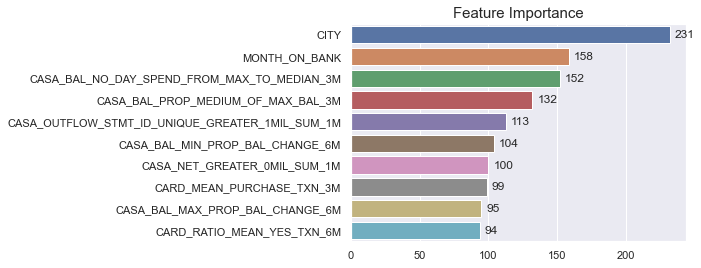

In [10]:
ml.plot_feature_importance()

Many of the top important feature are installed apps: `pd_app_com.shopee.id`, `ph_app_com.tangbull.phonerepayment` and `pd_app_com.kreditpintar`. Those contribute to best splits.

___
## explainable_ai

In [11]:
explainer = shap.TreeExplainer(ml.booster)
shap_values = explainer.shap_values(ml.train_feat)

/opt/anaconda3/lib/python3.8/site-packages/shap/explainers/_tree.py:351: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



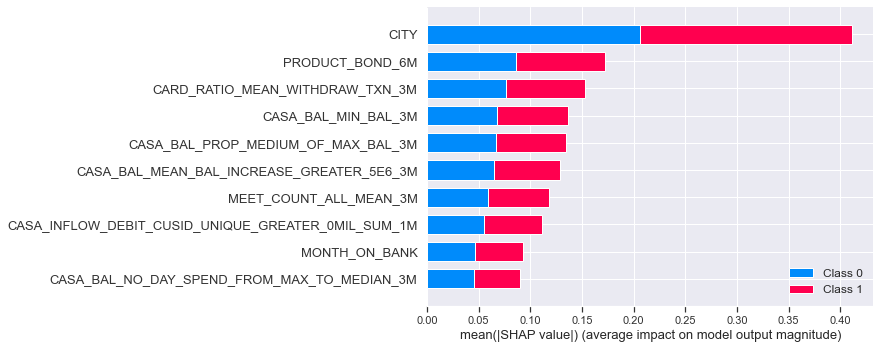

In [12]:
shap.summary_plot(shap_values, ml.train_feat, max_display=10)

Though the shapley value chart is not exactly the same as feature importance based on the tree splits (in previous chart), the top important ones stil remain.

In [16]:
sample_index = 10

shap.initjs()
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][sample_index,:],
    ml.train_feat.iloc[sample_index,:]
)

`shap` package can break down the prediction of a sample into contributions of every features. For example, the session index 10 has prediction of -2.19 (note that this is the log odds of the probability, inverse the function to get the probability). The contribution is intepreted as following:

1. `pd_app_com.shopee.id = 1` decreases significantly the chance it comes from a bad user.
2. `pd_call_total_calls = 28` decreases fairly the chance it comes from a bad user.
3. `de_employment_duration = 24` increases the chance it comes from a bad user.
4. ...

In [17]:
sample_index_from = 0
sample_index_to = 100

shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][sample_index_from: sample_index_to, :], 
    ml.train_feat.iloc[sample_index_from: sample_index_to,:]
)

Aggreate chart of contributions for many samples.

___
## test

In [19]:
true = ml.test_label
pred = ml.predict(ml.test_feat)

In [22]:
auc = mlframework.get_auc(true, pred)
print(f'AUC on test set is: {auc:.2%}')

AUC on test set is: 59.62%


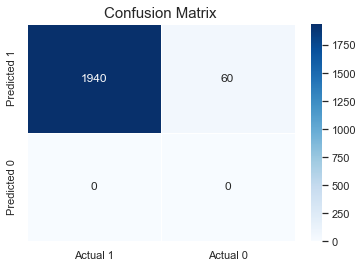

In [20]:
mlframework.get_confusion_matrix(true, pred)

Assume the cut-off is 0.5, most of the users are predict as good (as expected). From the confusion matrix, recall can be calculated as 0.157, precision can be calculate as 0.649. The cut-off needs to be considered carefully based on the context. Following part will justify the optimal cut-off.

In [23]:
mlframework.get_gain_table(true, pred)

,level,predict_min,predict_mean,predict_max,true_count,true_sum,true_mean
0,Level1,0.009040,0.046074,0.232992,200,14,0.070
1,Level2,0.001966,0.003952,0.008981,200,7,0.035
2,Level3,0.000982,0.001420,0.001965,200,4,0.020
3,Level4,0.000599,0.000772,0.000979,200,8,0.040
4,Level5,0.000365,0.000468,0.000598,200,4,0.020
5,Level6,0.000233,0.000290,0.000365,200,5,0.025
6,Level7,0.000151,0.000189,0.000233,200,7,0.035
7,Level8,0.000094,0.000120,0.000150,200,3,0.015
8,Level9,0.000046,0.000070,0.000094,200,4,0.020
9,Level10,0.000005,0.000029,0.000046,200,4,0.020


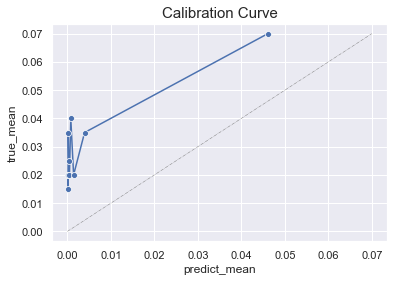

In [24]:
mlframework.plot_calibration_curve(true, pred)

It's better to examine the profitability on the test set only. Since the model learns from the train set so it's might be unfair for BAU (business as usual) to compare. But for simplicity, whole data (41,022 rows) are used.

In [18]:
def get_average_flag_bad(
    pred_score: list = None,
    approval_rate: float = 0.8,
    label: pd.Series = data['flag_bad']
):
    if pred_score is None:
        approval = label.sample(frac=approval_rate, random_state=0)
        average_flag_bad = approval.mean()
    else:
        if len(pred_score) !=  len(pred_score):
            raise ValueError('Size of prediction and true label must be equal.')
        pred_label = pd.DataFrame({
            'pred_score': pred_score,
            'label': label
        })
        approval_number = round(approval_rate * len(label))
        approval = pred_label.sort_values('pred_score').head(approval_number)
        average_flag_bad = approval['label'].mean()
    return average_flag_bad

In [19]:
def get_profit(
    pred_score: list = None,
    approval_rate: float = 0.8,
    label: pd.Series = data['flag_bad'],
    values: dict = {0: 100, 1: -650}
):
    if pred_score is None:
        approval = label.sample(frac=approval_rate, random_state=0)
        profit = approval.replace(values).sum()
    else:
        if len(pred_score) !=  len(pred_score):
            raise ValueError('Size of prediction and true label must be equal.')
        pred_label = pd.DataFrame({
            'pred_score': pred_score,
            'label': label
        })
        approval_number = round(approval_rate * len(label))
        approval = pred_label.sort_values('pred_score').head(approval_number)
        profit = approval['label'].replace(values).sum()
    return profit

In [20]:
pred_score = user_ml.predict(
    user_ml.data[user_ml.train_feat.columns]
)
pred_score

array([0.02699314, 0.09277559, 0.46961011, ..., 0.04326835, 0.01803737,
       0.11294207])

Prediction score (to be a bad user) on whole data set.

In [21]:
bau_flag_bad = get_average_flag_bad()
bau_profit = get_profit()

print('With approval rate of 80%:')
print(f'- Business as usual average flag bad: {bau_flag_bad:.1%}.')
print(f'- Business as usual profit: ${bau_profit:,}.')

With approval rate of 80%:
- Business as usual average flag bad: 13.1%.
- Business as usual profit: $68,050.


In [22]:
model_flag_bad  = get_average_flag_bad(pred_score)
model_profit  = get_profit(pred_score)

print('With approval rate of 80%:')
print(f'- Model average flag bad: {model_flag_bad:.1%}.')
print(f'- Model profit: ${model_profit:,}.')

With approval rate of 80%:
- Model average flag bad: 5.7%.
- Model profit: $1,889,050.


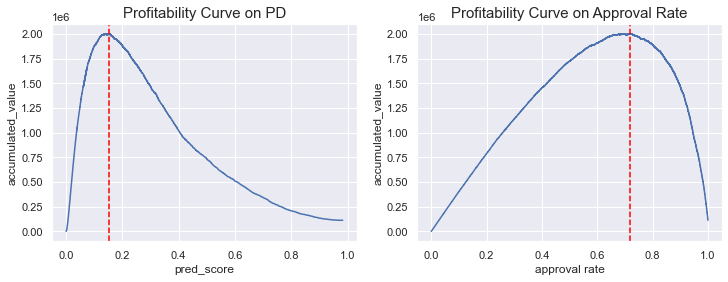

In [23]:
pred_label = pd.DataFrame({
    'pred_score': pred_score,
    'label': data['flag_bad']
})
values = {0: 100, 1: -650}
pred_label = (
    pred_label
    .sort_values('pred_score')
    .assign(value = lambda df: df['label'].replace(values))
    .assign(accumulated_value = lambda df: df['value'].cumsum())
    .reset_index(drop=True)
)

optimal_profit = pred_label['accumulated_value'].max()
optimal_index = pred_label['accumulated_value'].idxmax()
optimal_pd = pred_label['pred_score'][optimal_index]
optimal_approval_rate = (optimal_index + 1) / len(pred_label)
optimal_flag_bad = pred_label['label'][0: optimal_index + 1].mean()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.lineplot(
    x = pred_label['pred_score'],
    y = pred_label['accumulated_value']
)
plt.title('Profitability Curve on PD', size=15)
plt.axvline(optimal_pd, ls='--', color='red');
plt.subplot(1, 2, 2)
sns.lineplot(
    x = (pred_label.index + 1) / len(pred_label),
    y = pred_label['accumulated_value']
)
plt.xlabel('approval rate')
plt.title('Profitability Curve on Approval Rate', size=15)
plt.axvline(optimal_approval_rate, ls='--', color='red');

In [24]:
print(f'Optimal profit is ${optimal_profit:,}, which is achieved by PD cut-off {optimal_pd:.1%}.')
print(f'The according approval rate and average flag bad is {optimal_approval_rate:.1%} and {optimal_flag_bad:.1%}.')

Optimal profit is $2,001,200, which is achieved by PD cut-off 15.3%.
The according approval rate and average flag bad is 71.9% and 4.3%.


___

## table of contents
1. [overall](#overall)
2. [model](#model)
3. [explainable ai](#explainable_ai)
4. [test](#test)
5. [profitability](#profitability)

___